In [4]:
import pandas as pd

In [33]:
df = pd.read_csv('tiempo_vida_farmacias.csv')

In [34]:
df.columns

Index(['id', 'first_appearance', 'last_appearance', 'cve_loc', 'ageb',
       'cve_mun', 'longitud', 'latitud', 'estimated_death_date',
       'living_time'],
      dtype='object')

In [35]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np


In [36]:
# Selecciona las columnas de latitud y longitud para el clustering
X = df[['latitud', 'longitud']]

# Realiza el clustering con KMeans, elige el número de clusters (k) que creas adecuado
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

# Agrega los clusters al DataFrame
df['cluster'] = kmeans.labels_


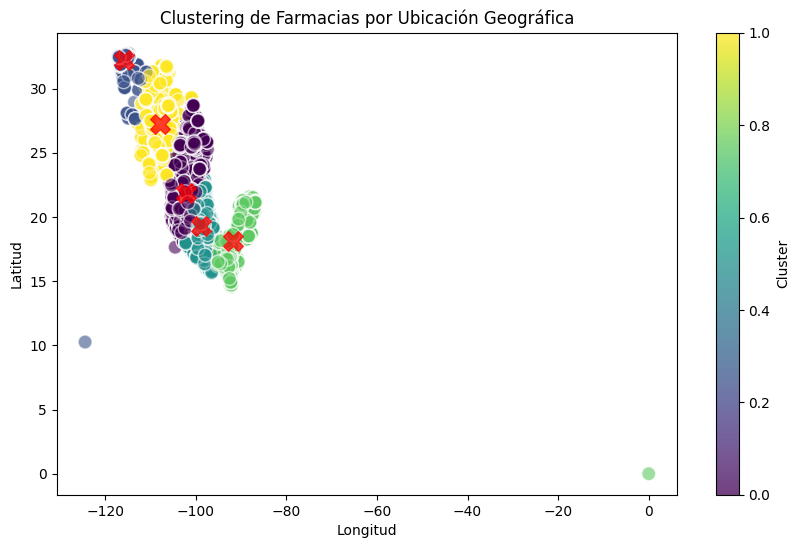

   cluster  living_time
0        0  2187.705222
1        1  2035.091804
2        2  2184.987452
3        3  2076.170027
4        4  2098.646676


In [37]:
import matplotlib.pyplot as plt
# Promedio de tiempo de vida por cluster
promedio_tiempo_vida_por_cluster = df.groupby('cluster')['living_time'].mean().reset_index()

# Visualización
plt.figure(figsize=(10, 6))

# Gráfico de dispersión de las farmacias con color según el cluster
plt.scatter(df['longitud'], df['latitud'], c=df['cluster'], cmap='viridis', s=100, alpha=0.6, edgecolor='w')

# Añadir centroides
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', s=200, alpha=0.75, marker='X')

# Etiquetas y título
plt.title('Clustering de Farmacias por Ubicación Geográfica')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='Cluster')

# Mostrar la gráfica
plt.show()

# Mostrar los resultados del promedio de tiempo de vida por cluster
print(promedio_tiempo_vida_por_cluster)

In [38]:
# Calcula los mínimos y máximos automáticamente en base a tus datos
lat_min = df['latitud'].min()
lat_max = df['latitud'].max()
lon_min = df['longitud'].min()
lon_max = df['longitud'].max()

# Si decides enfocarte solo en una región específica de México, podrías definir valores específicos:
# lat_min, lat_max = 14.0, 33.0  # Ejemplo de latitud para todo México
# lon_min, lon_max = -118.0, -86.0  # Ejemplo de longitud para todo México

# Opcional: eliminar outliers
df = df[(df['latitud'] > lat_min) & (df['latitud'] < lat_max)]
df = df[(df['longitud'] > lon_min) & (df['longitud'] < lon_max)]


/var/folders/0v/b_45vwgs76jg06_zy884q09c0000gn/T/ipykernel_38670/4100250608.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


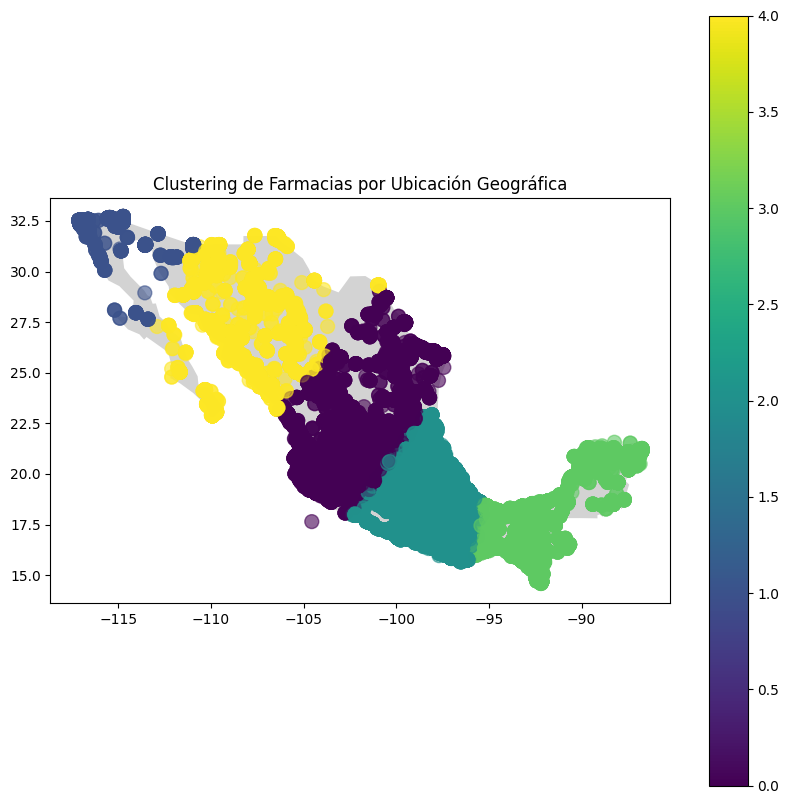

In [39]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Crear un GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitud, df.latitud))

# Asegurarse de que el GeoDataFrame esté en la proyección correcta
gdf.set_crs(epsg=4326, inplace=True)

# Cargar un mapa base de México en la proyección WGS84
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mexico = world[world.name == "Mexico"]

# Asegurarse de que el mapa base esté en la misma proyección
mexico = mexico.to_crs(epsg=4326)

# Plotear el mapa con los clusters
fig, ax = plt.subplots(figsize=(10, 10))
mexico.plot(ax=ax, color='lightgrey')

# Aumentar el tamaño de los puntos para asegurarse de que sean visibles
gdf.plot(ax=ax, column='cluster', cmap='viridis', markersize=100, alpha=0.6, legend=True)

plt.title('Clustering de Farmacias por Ubicación Geográfica')
plt.show()


# Objetivo Sub-Principal: Ver donde están las farmacias, es decir cómo se distribuyen geograficamente.
El primer approach será, 
Tener Long, Lat de todas las farmacias que hay actualmente en MX. 
Para esto usaremos los datos del denue más reciente 2023 y los vamos a visualizar para una comprensión más sencilla.
Después, recibiremos un .shp, ordenado en orden descendente, de los municipios que más dinero gastan en salud.
Estos gastos fueron extraidos a traves de una regresión.
Finalmente, juntaremos esto para ver, cuantas farmacias caben en cada municipio, jerarquizando estos lugares por su ubicación y su gasto en salud.

In [46]:
%cd Downloads/Denue

/Users/mny_1026/Downloads/Denue


Vamos a abrir los csv 2023 denue

In [49]:
import pandas as pd
d1 = pd.read_csv('d1.csv', encoding='latin1', low_memory=False)
d2 = pd.read_csv('d2.csv', encoding='latin1', low_memory=False)
d3 = pd.read_csv('d3.csv', encoding='latin1', low_memory=False)
d4 = pd.read_csv('d4.csv', encoding='latin1', low_memory=False)

In [51]:
def clean_column_names(df):
    # Clean special characters, convert to lowercase, and replace spaces with underscores
    df.columns = df.columns.str.encode('latin1').str.decode('utf-8')  # Decode to correct special characters
    df.columns = df.columns.str.lower()  # Convert to lowercase
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    df.columns = df.columns.str.replace('[^a-z0-9_]', '', regex=True)  # Remove non-alphanumeric characters except underscore
    
    # Check for duplicated column names and make them unique if necessary
    if df.columns.duplicated().any():
        df.columns = make_unique(df.columns)
    
    return df

# Function to make column names unique
def make_unique(columns):
    seen = {}
    new_columns = []
    for col in columns:
        if col not in seen:
            seen[col] = 1
            new_columns.append(col)
        else:
            seen[col] += 1
            new_columns.append(f"{col}_{seen[col]}")
    return new_columns

In [52]:
d1 = clean_column_names(d1)
d2 = clean_column_names(d2)
d3 = clean_column_names(d3)
d1 = clean_column_names(d4)

In [56]:
d_2023 = pd.concat([d1,d2,d3,d4],ignore_index=False)

In [67]:
d_2023.columns
scian_codes = [464111, 464112]
d_2023_f = d_2023[d_2023['codigo_act'].isin(scian_codes)]

In [69]:
d_2023_f.columns

Index(['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipocencom', 'nom_cencom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipounieco', 'latitud', 'longitud', 'fecha_alta'],
      dtype='object')

/var/folders/0v/b_45vwgs76jg06_zy884q09c0000gn/T/ipykernel_38670/4055670804.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


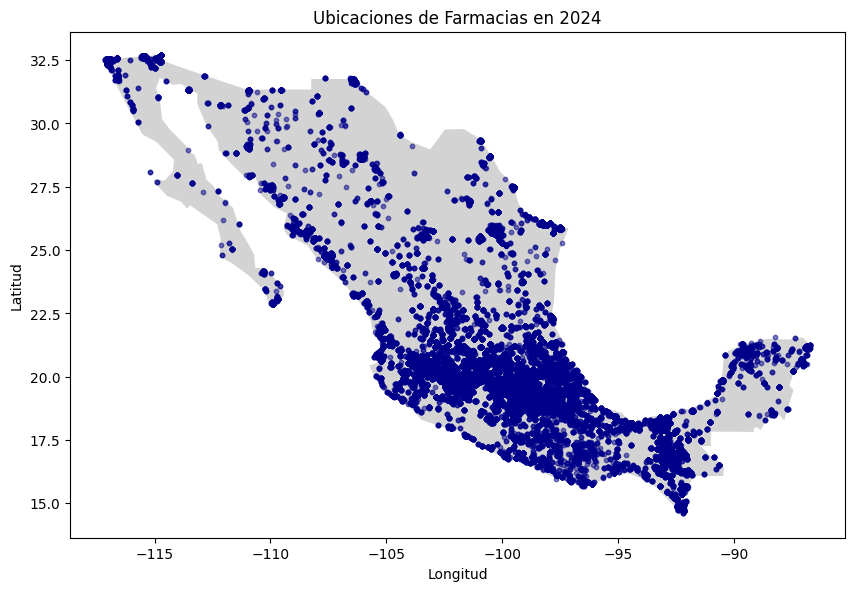

In [72]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Crear un GeoDataFrame a partir del DataFrame original
gdf = gpd.GeoDataFrame(d_2023_f, geometry=gpd.points_from_xy(d_2023_f.longitud, d_2023_f.latitud))

# Asegurarse de que el GeoDataFrame esté en la proyección correcta
gdf.set_crs(epsg=4326, inplace=True)

# Cargar un mapa base de México
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mexico = world[world.name == "Mexico"]

# Plotear el mapa con las ubicaciones de las farmacias
fig, ax = plt.subplots(figsize=(10, 10))
mexico.plot(ax=ax, color='lightgrey')

# Añadir las ubicaciones de las farmacias
gdf.plot(ax=ax, markersize=10, color='darkblue', alpha=0.5)

plt.title('Ubicaciones de Farmacias en 2024')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


In [74]:
import pandas as pd

# Supongamos que tienes un DataFrame con farmacias llamado df_farmacias
# y que incluye las columnas 'cve_mun' (clave del municipio), 'municipio', 'latitud', y 'longitud'

# Agrupar por 'cve_mun' y 'municipio' y calcular el promedio de 'latitud' y 'longitud'
df_grouped = d_2023_f.groupby(['cve_mun', 'municipio']).agg({
    'latitud': 'mean',    # Tomar el promedio de latitud para el centroide
    'longitud': 'mean',   # Tomar el promedio de longitud para el centroide
    'id': 'count'         # Contar el número de farmacias en el municipio
}).reset_index()

# Renombrar la columna de cuenta de farmacias
df_grouped = df_grouped.rename(columns={'id': 'farmacias_count'})

/var/folders/0v/b_45vwgs76jg06_zy884q09c0000gn/T/ipykernel_38670/572000543.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


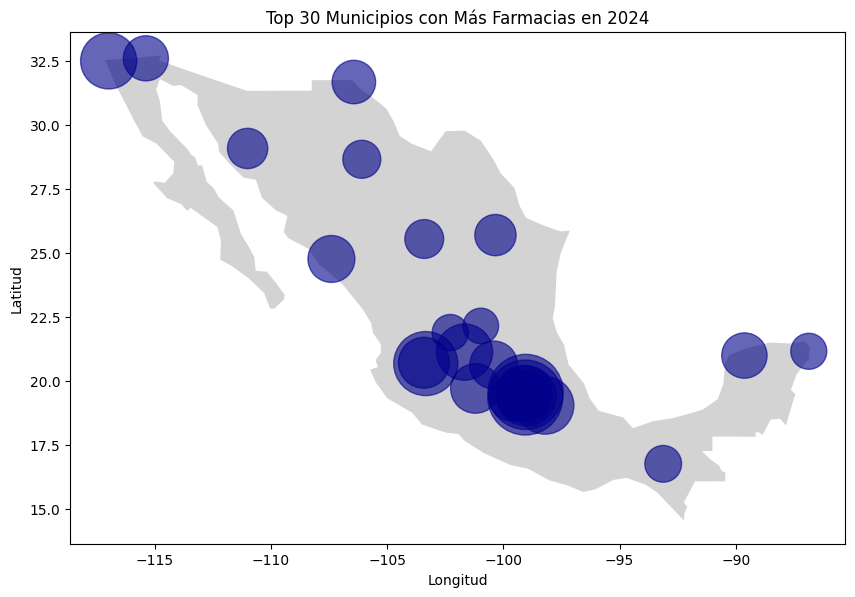

In [83]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Supongamos que ya tienes el DataFrame agrupado df_grouped con las columnas:
# 'cve_mun', 'municipio', 'latitud', 'longitud', 'farmacias_count'

# Paso 1: Filtrar el top 30 de municipios con más farmacias
df_top_30 = df_grouped.nlargest(40, 'farmacias_count')

# Paso 2: Crear un GeoDataFrame con las ubicaciones del centroide
gdf_top_30 = gpd.GeoDataFrame(df_top_30, geometry=gpd.points_from_xy(df_top_30.longitud, df_top_30.latitud))

# Asegurarse de que el GeoDataFrame esté en la proyección correcta
gdf_top_30.set_crs(epsg=4326, inplace=True)

# Paso 3: Cargar un mapa base de México
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
mexico = world[world.name == "Mexico"]

# Paso 4: Visualizar los municipios con el tamaño del punto proporcional al número de farmacias
fig, ax = plt.subplots(figsize=(10, 10))
mexico.plot(ax=ax, color='lightgrey')

# Añadir los puntos para cada municipio en el top 30
gdf_top_30.plot(ax=ax, markersize=gdf_top_30['farmacias_count'] * 2, color='darkblue', alpha=0.6, legend=True)

plt.title('Top 30 Municipios con Más Farmacias en 2024')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


In [84]:
df_top_30

,cve_mun,municipio,latitud,longitud,farmacias_count
754,33,Ecatepec de Morelos,19.564878,-99.038854,1465
194,7,Iztapalapa,19.345203,-99.055116,1458
869,39,Guadalajara,20.673467,-103.336879,1065
1156,58,Nezahualcóyotl,19.412253,-99.019065,934
1621,114,Puebla,19.036692,-98.200768,857
516,20,León,21.122032,-101.667989,822
137,5,Gustavo A. Madero,19.501878,-99.113726,821
113,4,Tijuana,32.506787,-116.981899,817
1653,120,Zapopan,20.705570,-103.414162,673
1094,53,Morelia,19.701073,-101.200004,638


Ahora que ya tenemos los municipios con mas farmacias, seguiremos nuestro analisis con la parte de sammyboy


In [88]:
%cd Downloads

/Users/mny_1026/Downloads


In [90]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Ruta al archivo .shp
shapefile_path = 'seccionesreal/SECCION.shp'
import geopandas as gpd
gdf = gpd.read_file(shapefile_path, engine='fiona')

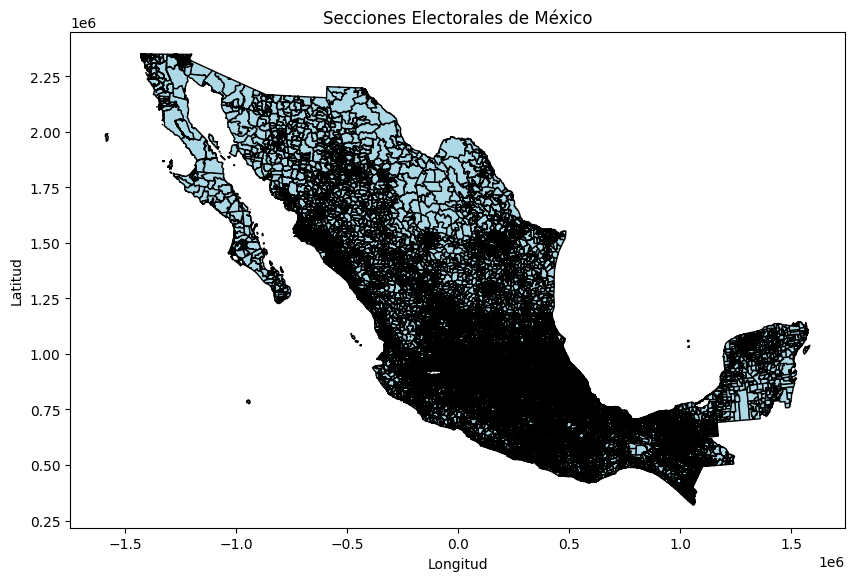

In [99]:
# Visualizar las secciones
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='lightblue', edgecolor='black')

plt.title('Secciones Electorales de México')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


ahora veamos el top 30 de gasto y cuantas hay que asignar

In [103]:

tp = pd.read_csv('top_30_municipalities.csv')

Ahora ya sabemos en que secciones electorales, hay que poner estas farmacias, veamos que secciones corresponden a que 

In [122]:
import matplotlib.colors as mcolors
gdf_filtrado = gdf.merge(tp, left_on=['ENTIDAD', 'MUNICIPIO'], right_on=['entidad', 'municipio'])
gdf_filtrado['grupo'] = gdf_filtrado['entidad'].astype(str) + '-' + gdf_filtrado['municipio'].astype(str)

In [131]:
secciones_por_grupo = gdf_filtrado.groupby('grupo').size().reset_index(name='num_secciones')
secciones_por_grupo

,grupo,num_secciones
0,11-20,736
1,14-120,471
2,14-39,12
3,15-104,21
4,15-106,32
5,15-109,32
6,15-118,15
7,15-121,44
8,15-122,115
9,15-13,168


In [136]:
d_2023_f.columns

Index(['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipocencom', 'nom_cencom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipounieco', 'latitud', 'longitud', 'fecha_alta'],
      dtype='object')

In [138]:
gdf_filtrado.columns

Index(['ID', 'ENTIDAD', 'DISTRITO_F', 'DISTRITO_L', 'MUNICIPIO', 'SECCION',
       'TIPO', 'Geometry1_', 'geometry', 'entidad', 'municipio',
       'cambio_gasto', 'farmacias_asignadas', 'grupo'],
      dtype='object')

In [145]:
import pandas as pd
import geopandas as gpd

# Paso 1: Convertir el DataFrame de farmacias en un GeoDataFrame
gdf_farmacias = gpd.GeoDataFrame(d_2023_f, 
                                 geometry=gpd.points_from_xy(d_2023_f.longitud, d_2023_f.latitud))

# Asegurarse de que el GeoDataFrame de farmacias está en el mismo CRS que las secciones
gdf_farmacias.set_crs(epsg=4326, inplace=True)  # Asume que ambos están en WGS 84

# Paso 2: Realizar un Spatial Join entre farmacias y secciones
gdf_joined = gpd.sjoin(gdf_farmacias, gdf, how="inner", op="within")

# Paso 3: Contar el número de farmacias por sección
farmacias_por_seccion = gdf_joined.groupby(['ENTIDAD', 'MUNICIPIO', 'SECCION']).size().reset_index(name='num_farmacias')



/Users/mny_1026/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [144]:
gdf = gdf.to_crs(epsg=4326)

# Verifica el CRS de ambos GeoDataFrames
print("CRS de gdf_farmacias:", gdf_farmacias.crs)
print("CRS de gdf:", gdf.crs)

CRS de gdf_farmacias: EPSG:4326
CRS de gdf: EPSG:4326


In [149]:
gdf_filtrado.columns

Index(['ID', 'ENTIDAD', 'DISTRITO_F', 'DISTRITO_L', 'MUNICIPIO', 'SECCION',
       'TIPO', 'Geometry1_', 'geometry', 'entidad', 'municipio',
       'cambio_gasto', 'farmacias_asignadas', 'grupo'],
      dtype='object')

In [152]:
gdf_farmacias.columns

Index(['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipocencom', 'nom_cencom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipounieco', 'latitud', 'longitud', 'fecha_alta', 'geometry'],
      dtype='object')

In [159]:
# Asegúrate de que ambos están en EPSG:4326
gdf_farmacias = gdf_farmacias.to_crs(epsg=4326)
gdf_filtrado = gdf_filtrado.to_crs(epsg=4326)


In [161]:
gdf_joined = gpd.sjoin(gdf_farmacias, gdf_filtrado, how="inner", op="within")

# Verificar si ahora hay coincidencias
print(f"Número de farmacias después del join: {len(gdf_joined)}")


Número de farmacias después del join: 8296


/Users/mny_1026/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [164]:
# Agrupar por 'grupo' y calcular el número de farmacias y las secciones relacionadas
farmacias_por_grupo = gdf_joined.groupby('grupo').agg(
    num_farmacias=('id', 'size'),  # Contar el número de farmacias en cada grupo
    secciones_relacionadas=('SECCION', lambda x: list(x.unique()))  # Listar las secciones únicas relacionadas con el grupo
).reset_index()

In [165]:
farmacias_por_grupo

,grupo,num_farmacias,secciones_relacionadas
0,11-20,822,"[3019, 1651, 3015, 1716, 1778, 1468, 1620, 184..."
1,14-120,673,"[3077, 3184, 2912, 3073, 3019, 3625, 3095, 322..."
2,14-39,20,"[553, 550, 549, 554, 555, 556, 557, 558, 551]"
3,15-104,27,"[4744, 4750, 4745, 4753, 4749, 4743, 4740, 473..."
4,15-106,7,"[5148, 5137]"
5,15-109,109,"[5464, 5455, 5475, 5473, 5477, 5458, 5468, 545..."
6,15-118,4,"[5808, 5807]"
7,15-121,158,"[5887, 5915, 5909, 5906, 5898, 5883, 5911, 588..."
8,15-122,322,"[1004, 948, 1029, 1010, 918, 1030, 961, 1033, ..."
9,15-13,431,"[314, 361, 300, 351, 390, 287, 395, 336, 329, ..."


In [167]:
gdf_filtrado

,ID,ENTIDAD,DISTRITO_F,DISTRITO_L,MUNICIPIO,SECCION,TIPO,Geometry1_,geometry,entidad,municipio,cambio_gasto,farmacias_asignadas,grupo,centroid
0,250211,11,3,3,20,1261,3,1`X_tp,"POLYGON ((-101.68584 21.22134, -101.68503 21.2...",11,20,59235.667500,3,11-20,POINT (33175.091 1022420.560)
1,250212,11,3,3,20,1262,2,1`X_tUf,"POLYGON ((-101.66839 21.21076, -101.66699 21.2...",11,20,59235.667500,3,11-20,POINT (34080.596 1021593.390)
2,250213,11,3,3,20,1263,2,1`X_tUF,"POLYGON ((-101.66493 21.20963, -101.66476 21.2...",11,20,59235.667500,3,11-20,POINT (34301.863 1021299.595)
3,250214,11,3,3,20,1264,2,1`X_tUF,"POLYGON ((-101.66630 21.20635, -101.66626 21.2...",11,20,59235.667500,3,11-20,POINT (34455.704 1021145.639)
4,250215,11,3,3,20,1265,2,1`X_tUF,"POLYGON ((-101.65733 21.19467, -101.65684 21.1...",11,20,59235.667500,3,11-20,POINT (35860.994 1020154.973)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6606,307207,30,17,27,131,3102,4,1`XQ=,"POLYGON ((-95.54753 17.63611, -95.55142 17.652...",30,131,22179.590313,1,30-131,POINT (682671.396 649339.165)
6607,307208,30,17,27,131,3103,3,1`XQ=,"POLYGON ((-95.35182 17.67568, -95.35188 17.675...",30,131,22179.590313,1,30-131,POINT (694388.917 647982.919)
6608,307209,30,17,27,131,3104,2,1`XQ?H(,"POLYGON ((-95.43627 17.63279, -95.43649 17.632...",30,131,22179.590313,1,30-131,POINT (696029.271 643656.676)
6609,307210,30,17,27,131,3105,4,1`XQ=,"POLYGON ((-95.43627 17.63279, -95.43637 17.632...",30,131,22179.590313,1,30-131,POINT (690080.295 640891.545)


     SECCION  num_farmacias
0       1971              1
333     2489              1
331     2484              1
330     2483              1
328     2477              1
..       ...            ...
55      2049              8
568     2801              8
239     2338              9
62      2062              9
23      2006             11

[701 rows x 2 columns]


/opt/homebrew/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


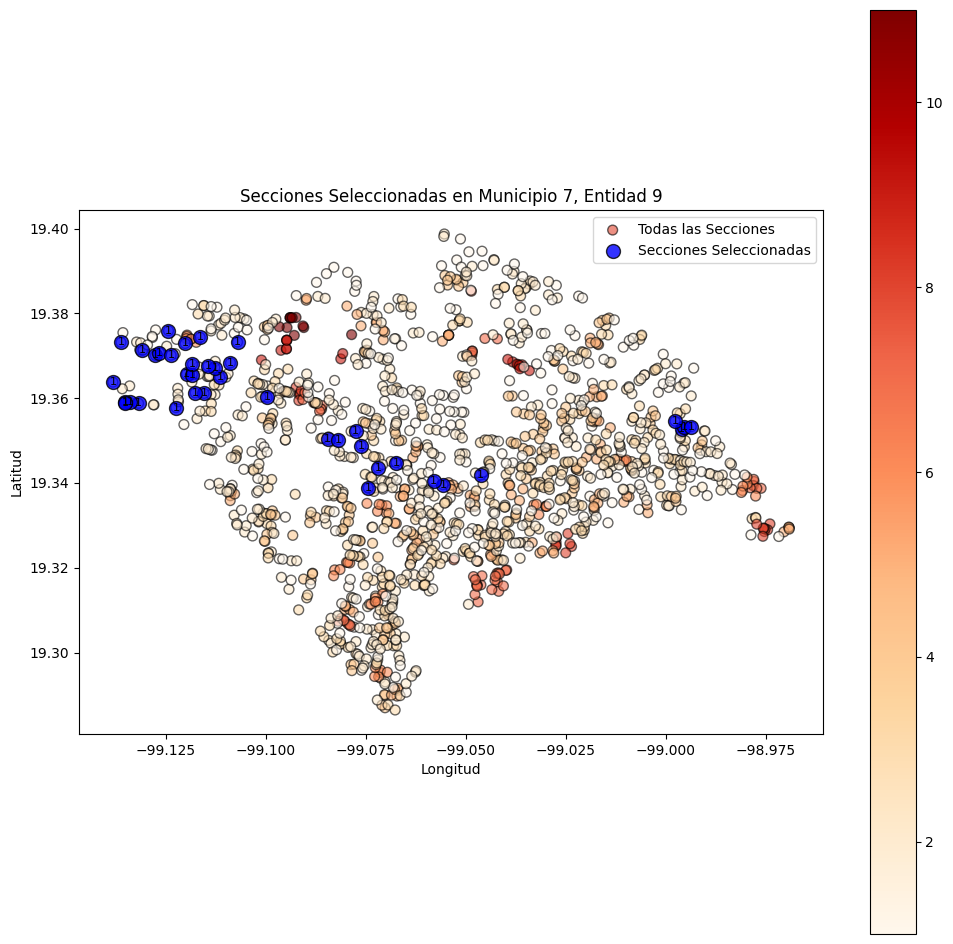

In [273]:
import pandas as pd
import geopandas as gpd

# Paso 1: Filtrar el GeoDataFrame para la entidad y municipio específicos
entidad_interes = 9
municipio_interes = 7

gdf_secciones_filtradas = gdf_joined[
    (gdf_joined['ENTIDAD'] == entidad_interes) &
    (gdf_joined['MUNICIPIO'] == municipio_interes)
]

# Paso 2: Contar las farmacias existentes en cada sección
farmacias_por_seccion = gdf_secciones_filtradas.groupby('SECCION').agg(
    num_farmacias=('id', 'size')  # Contar el número de farmacias en cada sección
).reset_index()

# Paso 3: Ordenar las secciones por el número de farmacias (de menor a mayor)
secciones_ordenadas = farmacias_por_seccion.sort_values(by='num_farmacias', ascending=True)

# Mostrar las secciones con menos farmacias
print(secciones_ordenadas)

# Paso 4: Seleccionar las mejores secciones para ubicar las nuevas farmacias
# Vamos a seleccionar las secciones con menos farmacias
secciones_para_ubicacion = secciones_ordenadas.head(39)  # Seleccionar las primeras 39 secciones

# Visualización opcional de las secciones seleccionadas
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import geopandas as gpd

# Mapa base (si tienes acceso a un mapa base)
# gdf_secciones_filtradas = gdf_secciones_filtradas.to_crs(epsg=3857)  # Reproyectar a Web Mercator si usas un fondo de mapa

# Paso 1: Preparar los datos para la visualización
gdf_secciones_filtradas['num_farmacias'] = gdf_secciones_filtradas['SECCION'].map(
    farmacias_por_seccion.set_index('SECCION')['num_farmacias']
).fillna(0)

# Paso 2: Configurar la visualización
fig, ax = plt.subplots(figsize=(12, 12))

# Opcional: Agregar fondo de mapa (por ejemplo, de OpenStreetMap)
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Dibujar las secciones y codificar por el número de farmacias
gdf_secciones_filtradas.plot(
    ax=ax, 
    column='num_farmacias', 
    cmap='OrRd',  # Cambia a otro colormap si lo prefieres
    legend=True, 
    edgecolor='black', 
    alpha=0.6,
    markersize=50,
    label='Todas las Secciones'
)

# Resaltar las secciones seleccionadas
gdf_secciones_filtradas[gdf_secciones_filtradas['SECCION'].isin(secciones_para_ubicacion['SECCION'])].plot(
    ax=ax, 
    color='blue', 
    edgecolor='black', 
    alpha=0.8, 
    markersize=100,  # Aumenta el tamaño para hacerlas más visibles
    label='Secciones Seleccionadas'
)

# Opcional: Añadir etiquetas para las secciones seleccionadas
for idx, row in gdf_secciones_filtradas[gdf_secciones_filtradas['SECCION'].isin(secciones_para_ubicacion['SECCION'])].iterrows():
    plt.text(
        row.geometry.centroid.x, 
        row.geometry.centroid.y, 
        str(int(row['num_farmacias'])),
        fontsize=8, 
        ha='center', 
        va='center'
    )

plt.title(f'Secciones Seleccionadas en Municipio {municipio_interes}, Entidad {entidad_interes}')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.show()




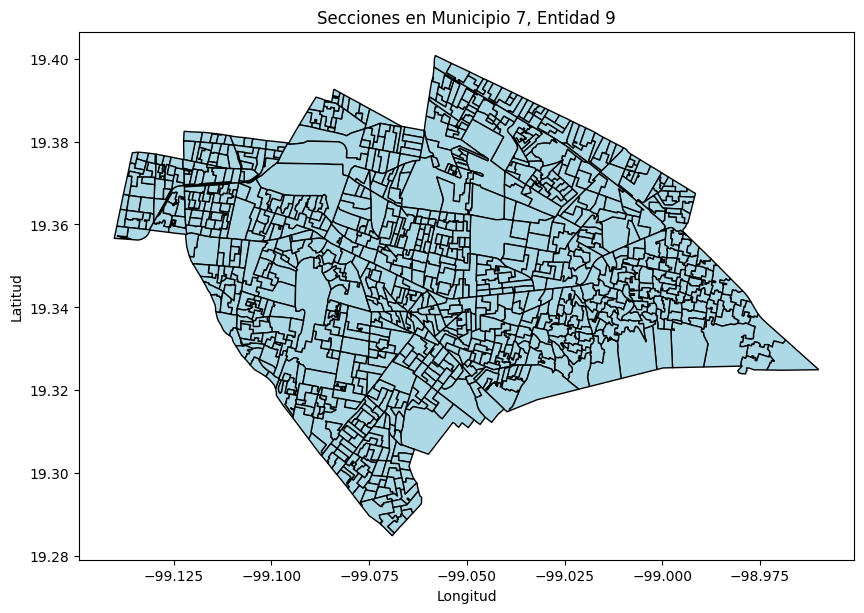

In [173]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Paso 1: Filtrar el GeoDataFrame para la entidad y municipio específicos
entidad_interes = 9
municipio_interes = 7

gdf_secciones_filtradas = gdf_filtrado[
    (gdf_filtrado['ENTIDAD'] == entidad_interes) &
    (gdf_filtrado['MUNICIPIO'] == municipio_interes)
]

# Paso 2: Visualizar las secciones filtradas en un mapa completo
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar las secciones
gdf_secciones_filtradas.plot(ax=ax, color='lightblue', edgecolor='black')

plt.title(f'Secciones en Municipio {municipio_interes}, Entidad {entidad_interes}')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


In [274]:
# Verificar el número de farmacias antes y después del filtrado
print("Número de farmacias antes del filtrado:", gdf_farmacias.shape[0])

# Asegúrate de filtrar por entidad y municipio correctos
gdf_farmacias_filtradas = gdf_farmacias[
    (gdf_farmacias['cve_ent'] == 9) &  # Reemplazar '9' con la entidad correcta
    (gdf_farmacias['cve_mun'] == 7)   # Reemplazar '7' con el municipio correcto
]

print("Número de farmacias después del filtrado:", gdf_farmacias_filtradas.shape[0])


Número de farmacias antes del filtrado: 63416
Número de farmacias después del filtrado: 1458


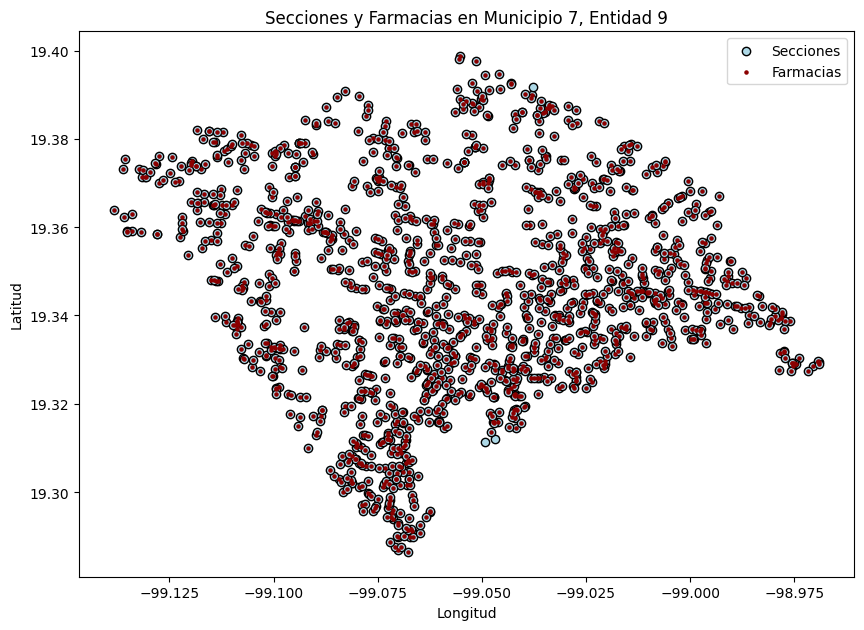

In [275]:
import matplotlib.pyplot as plt

# Crear una figura y un eje para la visualización
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar las secciones
gdf_secciones_filtradas.plot(ax=ax, color='lightblue', edgecolor='black', label='Secciones')

# Superponer las farmacias en rojo
gdf_farmacias_filtradas.plot(ax=ax, color='darkred', markersize=5, label='Farmacias')

# Configurar el título y las etiquetas
plt.title(f'Secciones y Farmacias en Municipio {municipio_interes}, Entidad {entidad_interes}')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()

# Mostrar la visualización
plt.show()


In [201]:
%cd Downloads

/Users/mny_1026/Downloads


In [202]:
datos = pd.read_csv('mc.csv')

In [207]:
# Filtrar columnas necesarias
df_poblacion_filtrado = datos[['ENTIDAD', 'MUN', 'AGEB', 'MZA', 'POBTOT']]


In [211]:
# Renombrar columnas en datos para que coincidan con gdf_secciones
df_poblacion_filtrado = datos.rename(columns={
    'MUN': 'MUNICIPIO',  # Renombrar MUN a MUNICIPIO para hacer match con gdf_secciones
    # Renombrar otras columnas si es necesario
})

# Filtrar las columnas necesarias
df_poblacion_filtrado = df_poblacion_filtrado[['ENTIDAD', 'MUNICIPIO', 'POBTOT']]  # Puedes incluir AGEB, MZA si son necesarias


In [213]:
# Unir los datos de población con las secciones
gdf_secciones_poblacion = gdf_secciones_filtradas.merge(
    df_poblacion_filtrado,
    on=['ENTIDAD', 'MUNICIPIO'],  # Puedes incluir AGEB, MZA si es necesario
    how='left'  # Usa 'left' para mantener todas las secciones, incluso si no tienen datos de población
)


In [214]:
# Calcular la densidad poblacional (habitantes por unidad de área)
gdf_secciones_poblacion['densidad_poblacional'] = gdf_secciones_poblacion['POBTOT'] / gdf_secciones_poblacion.geometry.area


/var/folders/0v/b_45vwgs76jg06_zy884q09c0000gn/T/ipykernel_38670/1258713255.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_secciones_poblacion['densidad_poblacional'] = gdf_secciones_poblacion['POBTOT'] / gdf_secciones_poblacion.geometry.area


In [215]:
import geopandas as gpd

# Paso 1: Reproyectar el GeoDataFrame a un CRS adecuado (por ejemplo, UTM)
gdf_secciones_poblacion = gdf_secciones_poblacion.to_crs(epsg=6372)

# Paso 2: Calcular el área con el CRS proyectado
gdf_secciones_poblacion['area_m2'] = gdf_secciones_poblacion.geometry.area

# Paso 3: Calcular la densidad poblacional
gdf_secciones_poblacion['densidad_poblacional'] = gdf_secciones_poblacion['POBTOT'] / gdf_secciones_poblacion['area_m2']

# Ahora puedes visualizar o trabajar con la densidad poblacional calculada correctamente.


In [220]:
print(gdf_secciones_poblacion.crs)
print(gdf_farmacias_filtradas.crs)


EPSG:6372
EPSG:4326


In [221]:
gdf_farmacias_filtradas = gdf_farmacias_filtradas.to_crs(gdf_secciones_poblacion.crs)


/var/folders/0v/b_45vwgs76jg06_zy884q09c0000gn/T/ipykernel_38670/3788892904.py:13: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


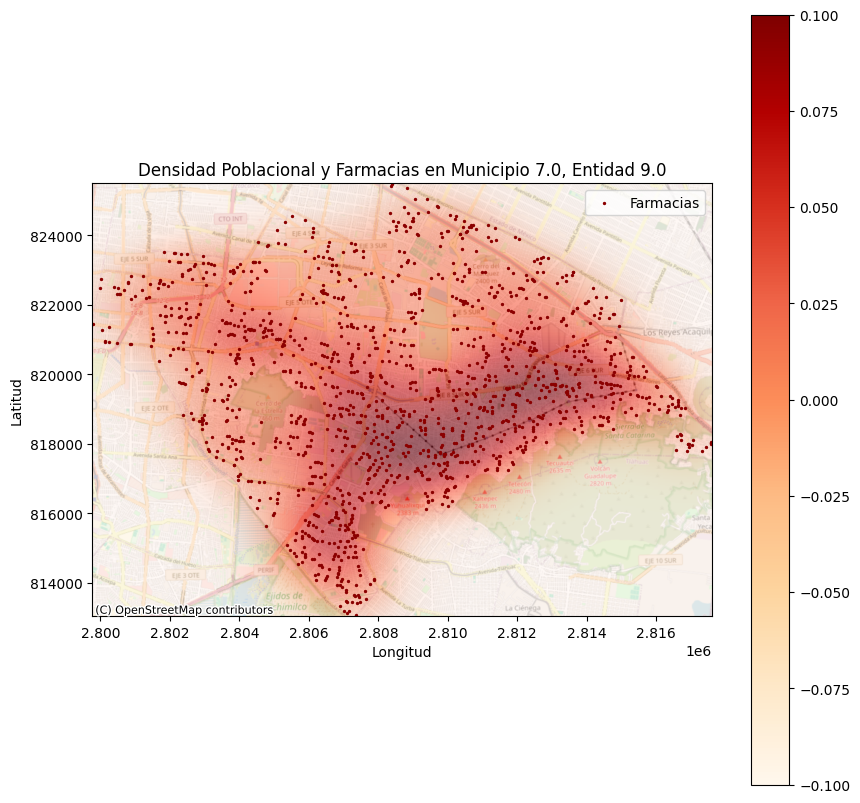

In [260]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import contextily as ctx


# Extraer las coordenadas de las farmacias
x = gdf_farmacias_filtradas.geometry.x
y = gdf_farmacias_filtradas.geometry.y

# Calcular el KDE (Kernel Density Estimation)
k = kde.gaussian_kde([x, y])
nbins = 300
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Crear la figura y el mapa base
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar el mapa base con las secciones y densidad poblacional
gdf_secciones_poblacion.plot(column='densidad_poblacional', ax=ax, cmap='OrRd', alpha=0.6, legend=True)

# Superponer el KDE en un mapa de calor
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='Reds', shading='auto', alpha=0.6)

# Superponer las farmacias en rojo
gdf_farmacias_filtradas.plot(ax=ax, color='darkred', markersize=2, label='Farmacias')
ctx.add_basemap(ax, crs=gdf_secciones_poblacion.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Configurar el título y las etiquetas
plt.title(f'Densidad Poblacional y Farmacias en Municipio {municipio_interes}, Entidad {entidad_interes}')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()

plt.show()


In [231]:
tp

,entidad,municipio,cambio_gasto,farmacias_asignadas
0,9,7,424059.260000,39
1,15,33,379029.735000,22
2,9,5,282703.535000,16
3,15,58,202295.710000,11
4,15,57,156831.692500,9
5,9,10,155859.877500,9
6,15,106,151263.423750,8
7,15,31,146195.755625,8
8,14,39,131902.545000,7
9,15,104,115377.734375,6


In [234]:
gdf_farmacias_filtradas.columns

Index(['id', 'clee', 'nom_estab', 'raz_social', 'codigo_act', 'nombre_act',
       'per_ocu', 'tipo_vial', 'nom_vial', 'tipo_v_e_1', 'nom_v_e_1',
       'tipo_v_e_2', 'nom_v_e_2', 'tipo_v_e_3', 'nom_v_e_3', 'numero_ext',
       'letra_ext', 'edificio', 'edificio_e', 'numero_int', 'letra_int',
       'tipo_asent', 'nomb_asent', 'tipocencom', 'nom_cencom', 'num_local',
       'cod_postal', 'cve_ent', 'entidad', 'cve_mun', 'municipio', 'cve_loc',
       'localidad', 'ageb', 'manzana', 'telefono', 'correoelec', 'www',
       'tipounieco', 'latitud', 'longitud', 'fecha_alta', 'geometry'],
      dtype='object')

In [261]:
# Verificar los nombres exactos y ajustar según corresponda
print(datos.columns)
print(gdf_secciones_filtradas.columns)


Index(['ENTIDAD', 'NOM_ENT', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB', 'MZA',
       'POBTOT', 'POBFEM', 'POBMAS',
       ...
       'VPH_TELEF', 'VPH_CEL', 'VPH_INTER', 'VPH_STVP', 'VPH_SPMVPI',
       'VPH_CVJ', 'VPH_SINRTV', 'VPH_SINLTC', 'VPH_SINCINT', 'VPH_SINTIC'],
      dtype='object', length=229)
Index(['ID', 'ENTIDAD', 'DISTRITO_F', 'DISTRITO_L', 'SECCION', 'TIPO',
       'Geometry1_', 'geometry', 'entidad', 'cambio_gasto',
       'farmacias_asignadas', 'grupo', 'centroid', 'num_farmacias_x',
       'num_farmacias_y', 'num_farmacias_secciones', 'num_farmacias', 'area'],
      dtype='object')


In [276]:
gdf_secciones_filtradas.head(5)

,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,SECCION,TIPO,Geometry1_,entidad_right,municipio_right,cambio_gasto,farmacias_asignadas,grupo,centroid,num_farmacias
71873,721446,09007464111010841000000000U5,COMERCIALIZADORA DE FARMACOS,FARMACIA DR DESCUENTO SA DE CV,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,AYUNTAMIENTO,CALLE,...,2049,2,1`X`PL,9,7,424059.26,39,9-7,POINT (304464.616 821212.315),8
80849,7793436,09007464111019671000000000U7,FARMACIA DE GENERICOS SIN NOMBRE,NaN,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,16 DE SEPTIEMBRE,CALLE,...,2049,2,1`X`PL,9,7,424059.26,39,9-7,POINT (304464.616 821212.315),8
83021,8377208,09007464111018211000000000U3,FARMACIA SIN NOMBRE,NaN,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,5 DE MAYO,CALLE,...,2049,2,1`X`PL,9,7,424059.26,39,9-7,POINT (304464.616 821212.315),8
83622,750902,09007464111012771000000000U2,FARMACIA JENNYNA,NaN,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,LERDO DE TEJADA,CALLE,...,2049,2,1`X`PL,9,7,424059.26,39,9-7,POINT (304464.616 821212.315),8
85174,8652427,09007464111017761000000000U8,FARMACIA SAN PATRICIO,NaN,464111,Farmacias sin minisúper,0 a 5 personas,CALLE,5 DE MAYO,CALLE,...,2049,2,1`X`PL,9,7,424059.26,39,9-7,POINT (304464.616 821212.315),8
